<h1 style="text-align: center">Traffic Sign Classifier using CNN</h1>

<img
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 70%;"
    src="https://www.nevron.com/NIMG.axd?i=Diagram/Shapes/TrafficSignsShapes/Traffic_signs_shapes.png" 
    alt="Image Description">
</img>

# Description

In this notebook, we will build a **deep learning model** to classify german traffic signs. 
Model is written **tensorflow keras** framework.
On this model, we will perform different kind of adversarial attacks.
Further we will perform adversarial trainings against these attacks to make to models more robust in real-life scenarios


## Data

We have use dataset on Kaggle. It's GTSRB - German Traffic Sign Recognition Benchmark. 
This dataset consist of 43 labels for 43 different type of traffic signs. We have around 50k images.

# 1. Import lib

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score

# 2. Utility Functions

In [2]:
def generate_data(csv_path, img_path, df = None, custom_data = 0):
    if custom_data == 0:
        #csv_path = "/kaggle/input/gtsrb-german-traffic-sign/Test.csv"
        #img_path = "/kaggle/input/gtsrb-german-traffic-sign"
        valid = pd.read_csv(csv_path)
    elif custom_data == 1:
        valid = df 
    
    valid_labels = valid['ClassId'].values.tolist()
    valid_img_path = img_path
    valid_imgs = valid['Path'].values
    valid_data = []
    for img in valid_imgs:
        im = Image.open(valid_img_path + '/' + img)
        im = im.resize((30,30))
        im = np.array(im)
        valid_data.append(im)
    valid_data = np.array(valid_data)
    valid_data = valid_data.astype('float32')
    return(valid_data,valid_labels,valid_imgs)

In [3]:
## Function to plot the Original image vs Predicted Image
def show_original_vs_prediction(data,model,n):
    predictions = model.predict(data)
    classes_x = np.argmax(predictions, axis = 1).tolist()
    classes_x = np.array([classes_x]).tolist()[0]
    number_of_image = n ##number of the image in the test/validation set
    image_name = images[number_of_image]
    print(image_name)
    image_label = label[number_of_image]
    print(image_label)
    plt.figure(0)
    path = img_path + '/' + image_name
    print(path)
    img = Image.open(path)
    plt.imshow(img)
    plt.title("Original Image")
    plt.figure(1)
    img_pre = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Meta/' + str(classes_x[number_of_image]) + '.png')
    plt.imshow(img_pre)
    plt.title("Predict Image")
    plt.show()

In [4]:
def get_index(pred):
    compare_df = pd.DataFrame({'y_test': y_test.argmax(axis=1), 'pred': pred})
    final_result = compare_df[compare_df['y_test']!=compare_df['pred']]
    index = final_result.index
    return(index)

In [5]:
def plot_original_vs_predicted_after_attack(n,idx,pred):
     # Assuming y_test and pred are your arrays/lists
    img_path = "/kaggle/input/gtsrb-german-traffic-sign"
    csv_path = "/kaggle/input/gtsrb-german-traffic-sign/Train.csv"
    df = pd.read_csv(csv_path)
    result_to_plot = df[df.index.isin(idx)]
    file_name = result_to_plot['Path'].values
    plt.figure(0)
    path = img_path + '/' + file_name
    if n is None:
        n = idx[0]
    print(path[n])
    img = Image.open(path[n])
    plt.imshow(img)
    plt.title("Test Image")
    plt.figure(1)
    img_pre = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Meta/' + str(pred[n]) + '.png')
    plt.imshow(img_pre)
    plt.title("Predict Image")
    plt.show()

In [6]:
def show_plot(n,pred):
    idx = get_index(pred)
    print(idx)
    plot_original_vs_predicted_after_attack(n,idx,pred)
    #else:
    #    raise TypeError("The number is not in the list!")    

In [7]:
## Function to plot the original Test image vs Attacked image
def plot_original_vs_attacked_img(x_test,model,n):
    pred = model.predict(x_test)
    classes_x = np.argmax(pred, axis = 1).tolist()
    classes_x = np.array([classes_x]).tolist()[0]
    number_of_image_test = n
    test_image_name = test_imgs[number_of_image_test]
    image_label = test_labels[number_of_image_test]
    plt.figure(0)
    img_path = test_img_path + '/' + test_image_name
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title("Test Image")
    plt.figure(1)
    img_pre = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Meta/' + str(classes_x[number_of_image_test]) + '.png')
    plt.imshow(img_pre)
    plt.title("Predict Image")
    plt.show()

In [8]:
label_mapping = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 
                     3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 
                     6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 
                     8: 'Speed limit (120km/h)', 9: 'No passing', 
                     10: 'No passing for vechiles over 3.5 metric tons', 
                     11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 
                     14: 'Stop', 15: 'No vechiles', 16: 'Vechiles over 3.5 metric tons prohibited', 
                     17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 
                     20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 
                     23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 
                     26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 
                     29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 
                     32: 'End of all speed and passing limits', 33: 'Turn right ahead', 
                     34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 
                     37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 
                     40: 'Roundabout mandatory', 41: 'End of no passing', 
                     42: 'End of no passing by vechiles over 3.5 metric tons'}

# 3. Data processing(resize, change datatype, split train test, )

In [9]:
imgs_path = "/kaggle/input/gtsrb-german-traffic-sign/Train"
data = []
labels = []
CLASSES = 43
# using for loop to access each image
for i in range(CLASSES):
    img_path = os.path.join(imgs_path, str(i)) #0-42
    for img in os.listdir(img_path):
        im = Image.open(imgs_path + '/' + str(i) + '/' + img)
        im = im.resize((30,30))
        im = np.array(im)
        data.append(im)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
#print("data[0]: ",data[0])
#print("labels[0: ]",labels[0])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_test.shape, y_test.shape)
# convert interge label to one-hot data
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(y_train[1])

training shape:  (31367, 30, 30, 3) (31367,)
testing shape:  (7842, 30, 30, 3) (7842,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 4. Build model by Keras

In [11]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

# 5. Train model

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
epochs = 15
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
491/491 [==============================] - 13s 6ms/step - loss: 2.1555 - accuracy: 0.4808 - val_loss: 0.3830 - val_accuracy: 0.9185
Epoch 2/15
491/491 [==============================] - 3s 5ms/step - loss: 0.6419 - accuracy: 0.8190 - val_loss: 0.2390 - val_accuracy: 0.9408
Epoch 3/15
491/491 [==============================] - 3s 5ms/step - loss: 0.4172 - accuracy: 0.8815 - val_loss: 0.1094 - val_accuracy: 0.9725
Epoch 4/15
491/491 [==============================] - 3s 6ms/step - loss: 0.3206 - accuracy: 0.9068 - val_loss: 0.0881 - val_accuracy: 0.9791
Epoch 5/15
491/491 [==============================] - 3s 5ms/step - loss: 0.2593 - accuracy: 0.9231 - val_loss: 0.0913 - val_accuracy: 0.9764
Epoch 6/15
491/491 [==============================] - 3s 5ms/step - loss: 0.2520 - accuracy: 0.9277 - val_loss: 0.0898 - val_accuracy: 0.9739
Epoch 7/15
491/491 [==============================] - 3s 5ms/step - loss: 0.2189 - accuracy: 0.9386 - val_loss: 0.0595 - val_accuracy: 0.9871
Epoch

# 6. Visualize loss and accuracy model

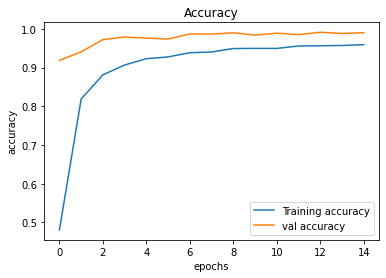

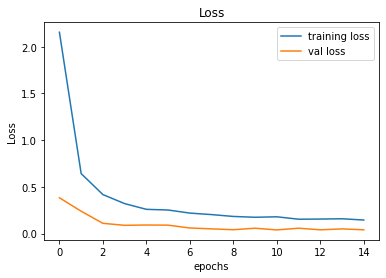

In [14]:
plt.figure(0) #underfitting
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('Accuracy.png')
plt.figure(1) #overfiting
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss.png')
plt.show()

# 7. Test model

In [15]:
from sklearn.metrics import accuracy_score
test = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")
test_labels = test['ClassId'].values.tolist()

test_img_path = "/kaggle/input/gtsrb-german-traffic-sign"
test_imgs = test['Path'].values
test_data = []

for img in test_imgs:
    im = Image.open(test_img_path + '/' + img)
    im = im.resize((30,30))
    im = np.array(im)
    test_data.append(im)
test_data = np.array(test_data)
predictions = model.predict(test_data)
classes_x = np.argmax(predictions, axis = 1).tolist()
classes_x = np.array([classes_x]).tolist()[0]

print("accuracy: ", accuracy_score(test_labels, classes_x))

accuracy:  0.9516231195566113


/kaggle/input/gtsrb-german-traffic-sign/Test/00000.png
16


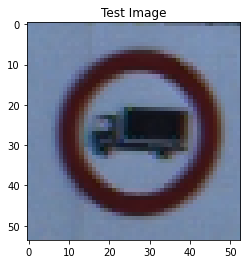

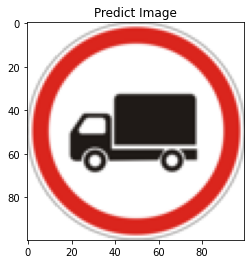

In [16]:
number_of_image_test = 0 #20
test_image_name = test_imgs[number_of_image_test]
image_label = test_labels[number_of_image_test]
plt.figure(0)
img_path = test_img_path + '/' + test_image_name
print(img_path)
img = Image.open(img_path)
plt.imshow(img)
plt.title("Test Image")
plt.figure(1)
print(classes_x[number_of_image_test])
img_pre = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Meta/' + str(classes_x[number_of_image_test]) + '.png')
plt.imshow(img_pre)
plt.title("Predict Image")
plt.show()

# 8. Install Adversarial-Robustness-Toolbox Framework

In [17]:
!pip install adversarial-robustness-toolbox torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00


## 8.1 Using ART Framework Train the Model

In [18]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [19]:
## Importing the ART framework
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool, HopSkipJump
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from keras.models import model_from_json

In [20]:
model_json = model.to_json()
model = model_from_json(model_json)
#model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier = KerasClassifier(model=model,clip_values=(0, 1), use_logits=False)

In [21]:
x_train = x_train.astype('float32')
classifier.fit(x_train, y_train, nb_epochs=15, batch_size=32)

Train on 31367 samples
Epoch 1/15
31367/31367 [==============================] - 6s 180us/sample - loss: 1.8185 - accuracy: 0.5296
Epoch 2/15
31367/31367 [==============================] - 5s 168us/sample - loss: 0.6660 - accuracy: 0.8064
Epoch 3/15
31367/31367 [==============================] - 5s 168us/sample - loss: 0.4898 - accuracy: 0.8577
Epoch 4/15
31367/31367 [==============================] - 5s 167us/sample - loss: 0.3846 - accuracy: 0.8866
Epoch 5/15
31367/31367 [==============================] - 5s 168us/sample - loss: 0.3463 - accuracy: 0.8988
Epoch 6/15
31367/31367 [==============================] - 5s 175us/sample - loss: 0.3152 - accuracy: 0.9083
Epoch 7/15
31367/31367 [==============================] - 5s 168us/sample - loss: 0.2988 - accuracy: 0.9134
Epoch 8/15
31367/31367 [==============================] - 5s 169us/sample - loss: 0.2694 - accuracy: 0.9234
Epoch 9/15
31367/31367 [==============================] - 5s 168us/sample - loss: 0.2688 - accuracy: 0.9236
Epoch

In [22]:
model.save('my_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Test/00003.png
33
/kaggle/input/gtsrb-german-traffic-sign/Test/00003.png


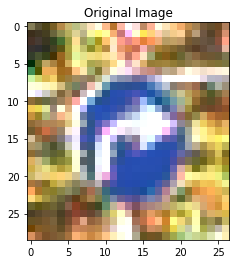

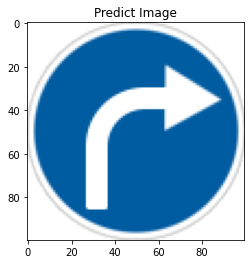

In [23]:
csv_path = "/kaggle/input/gtsrb-german-traffic-sign/Test.csv"
img_path = "/kaggle/input/gtsrb-german-traffic-sign"
data,label,images = generate_data(csv_path, img_path,custom_data = 0) 
show_original_vs_prediction(data=data,model=classifier,n=3)

## Attack 1 : Projected Gradient Descent

In [24]:
x_test = x_test.astype('float32')
# Perform an evasion attack (PGD) on the test samples
attack1 = ProjectedGradientDescent(estimator=classifier,eps=0.5,verbose=False,)
x_test_adv1 = attack1.generate(x=x_test,verbose=True)

In [25]:
# Test the model's accuracy on the adversarial test samples
predictions_adv1 = classifier.predict(x_test_adv1)
predictions_adv1 = predictions_adv1.argmax(axis=1)
accuracy_adv = accuracy_score(y_test.argmax(axis=1), predictions_adv1)
print(f"Adversarial test data accuracy: {accuracy_adv * 100:.2f}%")
print(f"Adversarial Attack Success Rate: {(1-accuracy_adv) * 100:.2f}%")

Adversarial test data accuracy: 98.10%
Adversarial Attack Success Rate: 1.90%


Int64Index([  88,  100,  119,  136,  147,  164,  176,  238,  259,  509,
            ...
            7458, 7479, 7488, 7499, 7650, 7672, 7772, 7775, 7801, 7815],
           dtype='int64', length=149)
/kaggle/input/gtsrb-german-traffic-sign/Train/3/00003_00002_00013.png


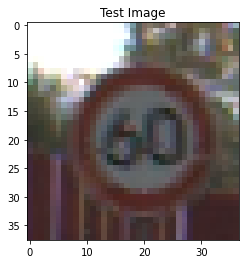

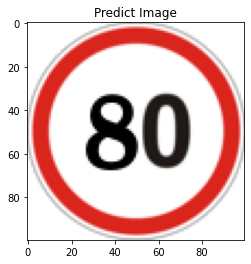

In [26]:
show_plot(None,predictions_adv1)

## Attack 2 : Fast Gradient Method

In [27]:
x_test = x_test.astype('float32')
# Perform an evasion attack (FGM) on the test samples
attack2 = FastGradientMethod(estimator=classifier, eps=0.9)
x_test_adv2 = attack2.generate(x=x_test)
# Test the model's accuracy on the adversarial test samples
predictions_adv2 = classifier.predict(x_test_adv2)
predictions_adv2 = predictions_adv2.argmax(axis=1)
accuracy_adv = accuracy_score(y_test.argmax(axis=1), predictions_adv2)
print(f"Adversarial test data accuracy: {accuracy_adv * 100:.2f}%") 
print(f"Adversarial Attack Success Rate: {(1-accuracy_adv) * 100:.2f}%")

Adversarial test data accuracy: 98.07%
Adversarial Attack Success Rate: 1.93%


Int64Index([  88,  100,  119,  136,  147,  164,  176,  238,  259,  509,
            ...
            7458, 7479, 7488, 7499, 7650, 7672, 7772, 7775, 7801, 7815],
           dtype='int64', length=151)
/kaggle/input/gtsrb-german-traffic-sign/Train/2/00002_00071_00025.png


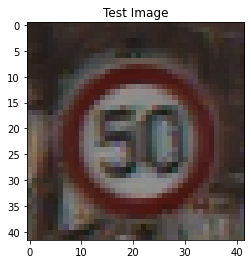

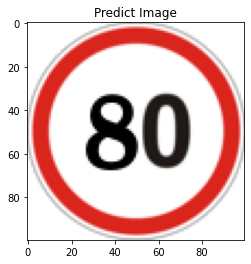

In [28]:
show_plot(None,predictions_adv2)

In [29]:
#compare_df = pd.DataFrame({'y_test': y_test.argmax(axis=1), 'pred': predictions_adv2})
#final_result = compare_df[compare_df['y_test']!=compare_df['pred']]
#final_result.head(10)

## Attack 3 : Hop Skip Jump 

In [30]:
# Perform an evasion attack (Hop Skip Jump) on the test samples
attack3 = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
x_test_adv3 = attack3.generate(x=x_test, verbose=True)
# Test the model's accuracy on the adversarial test samples
predictions_adv3 = classifier.predict(x_test_adv3)
predictions_adv3 = predictions_adv3.argmax(axis=1)
accuracy_adv = accuracy_score(y_test.argmax(axis=1), predictions_adv3)
print(f"Adversarial test data accuracy: {accuracy_adv * 100:.2f}%") 
print(f"Adversarial Attack Success Rate: {(1-accuracy_adv) * 100:.2f}%")

HopSkipJump:   0%|          | 0/7842 [00:00<?, ?it/s]

Adversarial test data accuracy: 93.80%
Adversarial Attack Success Rate: 6.20%


In [31]:
compare_df = pd.DataFrame({'y_test': y_test.argmax(axis=1), 'pred': predictions_adv3})
final_result = compare_df[compare_df['y_test']!=compare_df['pred']]
final_result.head(20)

,y_test,pred
17,5,12
24,5,12
29,5,12
30,5,3
31,5,12
33,5,12
34,5,8
45,5,12
48,5,12
88,3,8


Int64Index([  17,   24,   29,   30,   31,   33,   34,   45,   48,   88,
            ...
            7672, 7694, 7720, 7770, 7772, 7773, 7775, 7791, 7801, 7815],
           dtype='int64', length=486)
/kaggle/input/gtsrb-german-traffic-sign/Train/2/00002_00016_00017.png


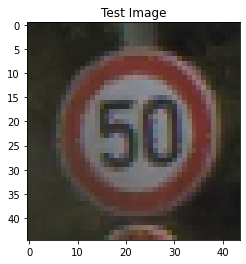

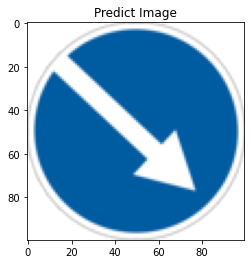

In [32]:
show_plot(196,predictions_adv3)

## Attack 4 : Deep Fool

In [33]:
x_test = x_test.astype('float32')
# Perform an evasion attack (DeepFool) on the test samples
attack4 = DeepFool(classifier, verbose = True, max_iter=10)
x_test_adv4 = attack4.generate(x=x_test, max_iter=10, verbose=True)
# Test the model's accuracy on the adversarial test samples
predictions_adv4 = classifier.predict(x_test_adv4)
predictions_adv4 = predictions_adv4.argmax(axis=1)
accuracy_adv = accuracy_score(y_test.argmax(axis=1), predictions_adv4)
print(f"Adversarial test data accuracy: {accuracy_adv * 100:.2f}%") 
print(f"Adversarial Attack Success Rate: {(1-accuracy_adv) * 100:.2f}%")

DeepFool:   0%|          | 0/7842 [00:00<?, ?it/s]

Adversarial test data accuracy: 3.72%
Adversarial Attack Success Rate: 96.28%


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841],
           dtype='int64', length=7550)
/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png


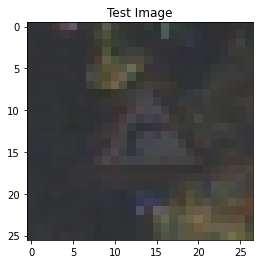

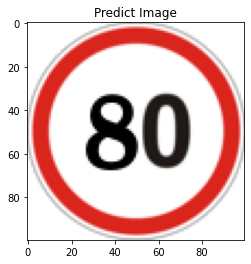

In [34]:
show_plot(None,predictions_adv4)

## Attack 5 : Laser Beam

In [35]:
from art.attacks.evasion.laser_attack.laser_attack import \
    LaserBeamAttack, LaserBeam
# Perform an evasion attack (FGM) on the test samples
attack5 = LaserBeamAttack(estimator=classifier,iterations=50,
                          max_laser_beam=(780, 3.14, 32, 32))

In [36]:
x_test = x_test.astype('float32')
x_test_adv5 = attack5.generate(x=x_test, verbose=True)
# Test the model's accuracy on the adversarial test samples
predictions_adv5 = classifier.predict(x_test_adv5)
predictions_adv5 = predictions_adv5.argmax(axis=1)
accuracy_adv = accuracy_score(y_test.argmax(axis=1), predictions_adv5)
print(f"Adversarial test data accuracy: {accuracy_adv * 100:.2f}%") 
print(f"Adversarial Attack Success Rate: {(1-accuracy_adv) * 100:.2f}%")

Adversarial test data accuracy: 4.64%
Adversarial Attack Success Rate: 95.36%


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841],
           dtype='int64', length=7478)
/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png


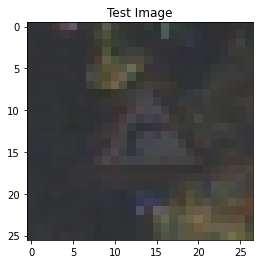

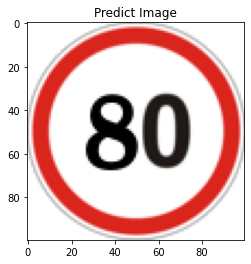

In [37]:
show_plot(None,predictions_adv5)

## Custom Attack - Wear & Tear

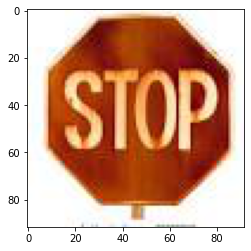

In [38]:
newTest = pd.DataFrame().reindex_like(test)
newTest = newTest.dropna()

newtest_img_path = "/kaggle/input/new-test-data/"
test_image_name = 'Stop-Rusted.jpg'
img_path = newtest_img_path + '/' + test_image_name
img = Image.open(img_path)
plt.imshow(img)

import cv2
# Load the image
image = cv2.imread(img_path)
# Get the image shape
height, width, channels = image.shape
# Extract the ROI coordinates (assuming the ROI is a rectangular bounding box)
x1, y1, x2, y2 = (100, 50, 200, 150)
metadata = {'Height': image.shape[0],
            'Width': image.shape[1],
            'ClassId': 14,
            'Roi.X1' : x1,'Roi.X2' : x2,
            'Roi.Y1' : y1,'Roi.Y2' : y2,
            'Path':img_path }

newTest = newTest.append(metadata, ignore_index=True)

[14]
accuracy:  1.0


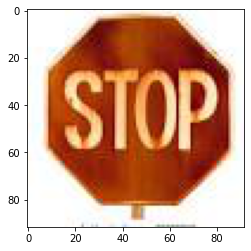

In [39]:
from sklearn.metrics import accuracy_score
newTest_labels = newTest['ClassId'].values.tolist()
newtest_img_path = "/kaggle/input/new-test-data/"
test_imgs = test['Path'].values
newtest_data = []
newtest_img_path = "/kaggle/input/new-test-data/"
test_image_name = 'Stop-Rusted.jpg'
img_path = newtest_img_path + '/' + test_image_name
img = Image.open(img_path)
plt.imshow(img)
im = img.resize((30,30))
im = np.array(im)
newtest_data.append(im)
newtest_data = np.array(newtest_data)
predictions = model.predict(newtest_data)
classes_x = np.argmax(predictions, axis = 1).tolist()
classes_x = np.array([classes_x]).tolist()[0]
print(classes_x)
print("accuracy: ", accuracy_score(newTest_labels, classes_x))

## Adversarial Training

In [40]:
attack,x_test_adv = attack1,x_test_adv1
# Defend the model against the evasion attack using adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
adv_trainer.fit(x_test, y_test, batch_size=100, nb_epochs=15)
# Retest the model's accuracy on the original test samples after adversarial training
predictions_def = adv_trainer.predict(x_test)
accuracy_def = accuracy_score(y_test.argmax(axis=1), predictions_def.argmax(axis=1))
print(f"Defended test data accuracy: {accuracy_def * 100:.2f}%")
# Retest the model's accuracy on the adversarial test samples after adversarial training
predictions_adv_def = adv_trainer.predict(x_test_adv)
accuracy_adv_def = accuracy_score(y_test.argmax(axis=1), predictions_adv_def.argmax(axis=1))
print(f"Defended adversarial test data accuracy: {accuracy_adv_def * 100:.2f}%")

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Defended test data accuracy: 99.76%
Defended adversarial test data accuracy: 99.77%


In [41]:
attack,x_test_adv = attack2,x_test_adv2
# Defend the model against the evasion attack using adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
adv_trainer.fit(x_test, y_test, batch_size=100, nb_epochs=15)
# Retest the model's accuracy on the original test samples after adversarial training
predictions_def = adv_trainer.predict(x_test)
accuracy_def = accuracy_score(y_test.argmax(axis=1), predictions_def.argmax(axis=1))
print(f"Defended test data accuracy: {accuracy_def * 100:.2f}%")
# Retest the model's accuracy on the adversarial test samples after adversarial training
predictions_adv_def = adv_trainer.predict(x_test_adv)
accuracy_adv_def = accuracy_score(y_test.argmax(axis=1), predictions_adv_def.argmax(axis=1))
print(f"Defended adversarial test data accuracy: {accuracy_adv_def * 100:.2f}%")

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Defended test data accuracy: 99.97%
Defended adversarial test data accuracy: 99.97%


In [42]:
attack,x_test_adv = attack3,x_test_adv3
# Defend the model against the evasion attack using adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
adv_trainer.fit(x_test, y_test, batch_size=100, nb_epochs=15)
# Retest the model's accuracy on the original test samples after adversarial training
predictions_def = adv_trainer.predict(x_test)
accuracy_def = accuracy_score(y_test.argmax(axis=1), predictions_def.argmax(axis=1))
print(f"Defended test data accuracy: {accuracy_def * 100:.2f}%")
# Retest the model's accuracy on the adversarial test samples after adversarial training
predictions_adv_def = adv_trainer.predict(x_test_adv)
accuracy_adv_def = accuracy_score(y_test.argmax(axis=1), predictions_adv_def.argmax(axis=1))
print(f"Defended adversarial test data accuracy: {accuracy_adv_def * 100:.2f}%")

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Defended test data accuracy: 99.92%
Defended adversarial test data accuracy: 95.18%


In [43]:
attack,x_test_adv = attack4,x_test_adv4
# Defend the model against the evasion attack using adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
adv_trainer.fit(x_test, y_test, batch_size=100, nb_epochs=15)
# Retest the model's accuracy on the original test samples after adversarial training
predictions_def = adv_trainer.predict(x_test)
accuracy_def = accuracy_score(y_test.argmax(axis=1), predictions_def.argmax(axis=1))
print(f"Defended test data accuracy: {accuracy_def * 100:.2f}%")
# Retest the model's accuracy on the adversarial test samples after adversarial training
predictions_adv_def = adv_trainer.predict(x_test_adv)
accuracy_adv_def = accuracy_score(y_test.argmax(axis=1), predictions_adv_def.argmax(axis=1))
print(f"Defended adversarial test data accuracy: {accuracy_adv_def * 100:.2f}%")

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Defended test data accuracy: 99.63%
Defended adversarial test data accuracy: 6.32%


In [44]:
attack,x_test_adv = attack5,x_test_adv5
# Defend the model against the evasion attack using adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
adv_trainer.fit(x_test, y_test, batch_size=100, nb_epochs=15)
# Retest the model's accuracy on the original test samples after adversarial training
predictions_def = adv_trainer.predict(x_test)
accuracy_def = accuracy_score(y_test.argmax(axis=1), predictions_def.argmax(axis=1))
print(f"Defended test data accuracy: {accuracy_def * 100:.2f}%")
# Retest the model's accuracy on the adversarial test samples after adversarial training
predictions_adv_def = adv_trainer.predict(x_test_adv)
accuracy_adv_def = accuracy_score(y_test.argmax(axis=1), predictions_adv_def.argmax(axis=1))
print(f"Defended adversarial test data accuracy: {accuracy_adv_def * 100:.2f}%")

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/15 [00:00<?, ?it/s]

IndexError: arrays used as indices must be of integer (or boolean) type

predictions_adv_def.argmax(axis=1)